Loading Training data.

---


Removing few special characters.

In [1]:
import numpy as np
import pandas as pd
import os
data = []
target = []
f = open("/content/drive/MyDrive/dataset/nlp_train_dataset.txt", "r")
rowtext = []
rowtarget = []
for line in f:
  if line == "\n":
    data.append(rowtext)
    target.append(rowtarget)
    rowtext = []
    rowtarget = []
  else:
    s=line.split()
    if s[0]!="." and s[0]!=",":
      rowtext.append(s[0])
    if s[1]!="." and s[1]!=",":
      rowtarget.append(s[1])
print(data[0])

['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', 'due', 'for', 'release', 'tomorrow', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits']


In [2]:
df = pd.DataFrame(columns=["text","target"])
df["text"] = data
df["target"] = target

In [3]:
df.head()

,text,target
0,"[Confidence, in, the, pound, is, widely, expec...","[NN, IN, DT, NN, VBZ, RB, VBN, TO, VB, DT, JJ,..."
1,"[Chancellor, of, the, Exchequer, Nigel, Lawson...","[NNP, IN, DT, NNP, NNP, NNP, POS, VBN, NN, TO,..."
2,"[But, analysts, reckon, underlying, support, f...","[CC, NNS, VBP, VBG, NN, IN, NN, VBZ, VBN, VBN,..."
3,"[This, has, increased, the, risk, of, the, gov...","[DT, VBZ, VBN, DT, NN, IN, DT, NN, VBG, VBN, T..."
4,"[``, The, risks, for, sterling, of, a, bad, tr...","[``, DT, NNS, IN, NN, IN, DT, JJ, NN, NN, VBP,..."


In [4]:
print(len(df["text"][0]))
print(len(df["target"][0]))

34
34


In [5]:
for i in range(len(df["text"].head(1)[0])):
  print(df["text"].head(1)[0][i] + "||"+ df["target"].head(1)[0][i])

Confidence||NN
in||IN
the||DT
pound||NN
is||VBZ
widely||RB
expected||VBN
to||TO
take||VB
another||DT
sharp||JJ
dive||NN
if||IN
trade||NN
figures||NNS
for||IN
September||NNP
due||JJ
for||IN
release||NN
tomorrow||NN
fail||VB
to||TO
show||VB
a||DT
substantial||JJ
improvement||NN
from||IN
July||NNP
and||CC
August||NNP
's||POS
near-record||JJ
deficits||NNS


In [6]:
import gensim
w2v_model = gensim.models.Word2Vec(df["text"], size=100, window=5, min_count=1, workers=4)

X = np.zeros((len(df["text"]), 100))
for i, sentence in enumerate(df["text"]):
    for word in sentence:
        X[i] += w2v_model.wv[word]
    X[i] /= len(sentence)

Creating dictionary of Features

In [7]:
unique_targets = []
for i in target:
  for j in i:
    if j not in unique_targets:
      unique_targets.append(j)

In [8]:
print(unique_targets)

['NN', 'IN', 'DT', 'VBZ', 'RB', 'VBN', 'TO', 'VB', 'JJ', 'NNS', 'NNP', 'CC', 'POS', 'VBP', 'VBG', 'PRP$', 'CD', '``', "''", 'VBD', 'EX', 'MD', '#', '(', '$', ')', 'NNPS', 'PRP', 'JJS', 'WP', 'RBR', 'JJR', 'WDT', 'WRB', 'RBS', 'PDT', 'RP', ':', 'FW', 'WP$', 'SYM', 'UH']


In [9]:
tag_to_id = {}
k = 0
for i in unique_targets:
  tag_to_id[i] = k
  k+=1
print(tag_to_id)

{'NN': 0, 'IN': 1, 'DT': 2, 'VBZ': 3, 'RB': 4, 'VBN': 5, 'TO': 6, 'VB': 7, 'JJ': 8, 'NNS': 9, 'NNP': 10, 'CC': 11, 'POS': 12, 'VBP': 13, 'VBG': 14, 'PRP$': 15, 'CD': 16, '``': 17, "''": 18, 'VBD': 19, 'EX': 20, 'MD': 21, '#': 22, '(': 23, '$': 24, ')': 25, 'NNPS': 26, 'PRP': 27, 'JJS': 28, 'WP': 29, 'RBR': 30, 'JJR': 31, 'WDT': 32, 'WRB': 33, 'RBS': 34, 'PDT': 35, 'RP': 36, ':': 37, 'FW': 38, 'WP$': 39, 'SYM': 40, 'UH': 41}


In [10]:
y = np.zeros((len(df["target"]), len(tag_to_id)))
for i, pos_tag in enumerate(df["target"]):
    for tag in pos_tag:
        y[i, tag_to_id[tag]] = 1

In [11]:
maxlength = 0
for i in df["text"]:
  if len(i)>maxlength:
    maxlength = len(i)
print(maxlength)

73


In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

Padding

---


Training and Testing data split

In [13]:
X_padded = pad_sequences(X, maxlen=maxlength, padding="post", truncating="post")
Y_padded = pad_sequences(y, maxlen=maxlength, padding="post", truncating="post")

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_padded,Y_padded,test_size=0.3, random_state=0, shuffle=True)

RNN Model

In [15]:
GLOVE_DIR = "/content/drive/MyDrive/dataset/glove.6B.300d.txt"  # path to pre-trained GloVe embeddings
EMBEDDING_DIM = 300

embeddings_index = {}
with open(GLOVE_DIR) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
VALIDATION_SPLIT = 0.2
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df["text"])
sequences = tokenizer.texts_to_sequences(df["text"])

word_index = tokenizer.word_index

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(df["target"])
Y_encoded = tag_tokenizer.texts_to_sequences(df["target"])



X_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding="post")


In [17]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
print("Embeddings shape: {}".format(embedding_matrix.shape))

Embeddings shape: (17257, 300)


In [19]:
from keras.utils.np_utils import to_categorical
Y = to_categorical(Y_padded)

In [20]:
np.shape(Y)

(8936, 100, 43)

In [21]:
NUM_CLASSES = Y.shape[2]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_padded,Y,test_size=0.2, random_state=0, shuffle=True)

In [22]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(x_train.shape))
print('Shape of output sequences: {}'.format(y_train.shape))
print("TESTING DATA")
print('Shape of input sequences: {}'.format(x_test.shape))
print('Shape of output sequences: {}'.format(y_test.shape))

TRAINING DATA
Shape of input sequences: (7148, 100)
Shape of output sequences: (7148, 100, 43)
TESTING DATA
Shape of input sequences: (1788, 100)
Shape of output sequences: (1788, 100, 43)


In [23]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, SimpleRNN, TimeDistributed, RNN, GRU, Bidirectional
from tensorflow.keras.models import Sequential
rnn_model = Sequential()
rnn_model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation="softmax")))
rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(rnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         5177100   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          23360     
                                                                 
 time_distributed (TimeDistr  (None, None, 43)         2795      
 ibuted)                                                         
                                                                 
Total params: 5,203,255
Trainable params: 26,155
Non-trainable params: 5,177,100
_________________________________________________________________
None


In [24]:
history = rnn_model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=128)

Epoch 1/30
45/45 [==============================] - 8s 123ms/step - loss: 1.6161 - accuracy: 0.7185 - val_loss: 0.6880 - val_accuracy: 0.8266
Epoch 2/30
45/45 [==============================] - 5s 100ms/step - loss: 0.6447 - accuracy: 0.8346 - val_loss: 0.6153 - val_accuracy: 0.8387
Epoch 3/30
45/45 [==============================] - 4s 94ms/step - loss: 0.5951 - accuracy: 0.8435 - val_loss: 0.5807 - val_accuracy: 0.8459
Epoch 4/30
45/45 [==============================] - 6s 131ms/step - loss: 0.5609 - accuracy: 0.8495 - val_loss: 0.5548 - val_accuracy: 0.8505
Epoch 5/30
45/45 [==============================] - 6s 128ms/step - loss: 0.5377 - accuracy: 0.8541 - val_loss: 0.5351 - val_accuracy: 0.8553
Epoch 6/30
45/45 [==============================] - 4s 97ms/step - loss: 0.5194 - accuracy: 0.8576 - val_loss: 0.5193 - val_accuracy: 0.8581
Epoch 7/30
45/45 [==============================] - 6s 123ms/step - loss: 0.5047 - accuracy: 0.8603 - val_loss: 0.5064 - val_accuracy: 0.8601
Epoch 8/

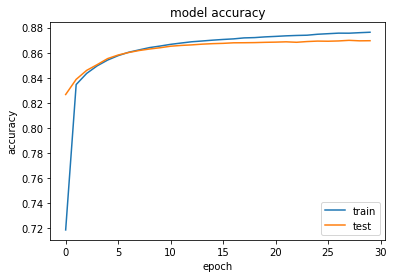

In [25]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

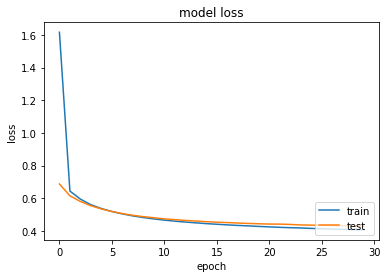

In [26]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

LSTM Model

In [27]:
lstm_model = Sequential()
lstm_model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         5177100   
                                                                 
 lstm (LSTM)                 (None, None, 64)          93440     
                                                                 
 time_distributed_1 (TimeDis  (None, None, 43)         2795      
 tributed)                                                       
                                                                 
Total params: 5,273,335
Trainable params: 5,273,335
Non-trainable params: 0
_________________________________________________________________


In [28]:
lstm_training = lstm_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
45/45 [==============================] - 13s 196ms/step - loss: 1.7612 - accuracy: 0.7834 - val_loss: 0.7001 - val_accuracy: 0.8225
Epoch 2/10
45/45 [==============================] - 5s 109ms/step - loss: 0.6468 - accuracy: 0.8324 - val_loss: 0.6172 - val_accuracy: 0.8379
Epoch 3/10
45/45 [==============================] - 4s 80ms/step - loss: 0.5833 - accuracy: 0.8451 - val_loss: 0.5637 - val_accuracy: 0.8484
Epoch 4/10
45/45 [==============================] - 6s 126ms/step - loss: 0.5314 - accuracy: 0.8567 - val_loss: 0.5178 - val_accuracy: 0.8605
Epoch 5/10
45/45 [==============================] - 3s 61ms/step - loss: 0.4877 - accuracy: 0.8671 - val_loss: 0.4817 - val_accuracy: 0.8677
Epoch 6/10
45/45 [==============================] - 4s 81ms/step - loss: 0.4532 - accuracy: 0.8738 - val_loss: 0.4550 - val_accuracy: 0.8720
Epoch 7/10
45/45 [==============================] - 2s 42ms/step - loss: 0.4263 - accuracy: 0.8785 - val_loss: 0.4360 - val_accuracy: 0.8748
Epoch 8/1

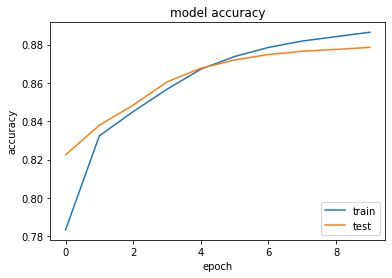

In [29]:
from matplotlib import pyplot as plt
plt.plot(lstm_training.history['accuracy'])
plt.plot(lstm_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

GRU Model

In [30]:
gru_model = Sequential()
gru_model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         5177100   
                                                                 
 gru (GRU)                   (None, None, 64)          70272     
                                                                 
 time_distributed_2 (TimeDis  (None, None, 43)         2795      
 tributed)                                                       
                                                                 
Total params: 5,250,167
Trainable params: 5,250,167
Non-trainable params: 0
_________________________________________________________________


In [31]:
gru_training = gru_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.3)

Epoch 1/10
40/40 [==============================] - 7s 130ms/step - loss: 1.9327 - accuracy: 0.8100 - val_loss: 0.6511 - val_accuracy: 0.8275
Epoch 2/10
40/40 [==============================] - 5s 138ms/step - loss: 0.6084 - accuracy: 0.8374 - val_loss: 0.5725 - val_accuracy: 0.8485
Epoch 3/10
40/40 [==============================] - 3s 69ms/step - loss: 0.5449 - accuracy: 0.8555 - val_loss: 0.5237 - val_accuracy: 0.8606
Epoch 4/10
40/40 [==============================] - 3s 82ms/step - loss: 0.4996 - accuracy: 0.8658 - val_loss: 0.4866 - val_accuracy: 0.8682
Epoch 5/10
40/40 [==============================] - 4s 96ms/step - loss: 0.4645 - accuracy: 0.8729 - val_loss: 0.4591 - val_accuracy: 0.8725
Epoch 6/10
40/40 [==============================] - 2s 61ms/step - loss: 0.4371 - accuracy: 0.8770 - val_loss: 0.4376 - val_accuracy: 0.8749
Epoch 7/10
40/40 [==============================] - 2s 63ms/step - loss: 0.4146 - accuracy: 0.8800 - val_loss: 0.4201 - val_accuracy: 0.8774
Epoch 8/10


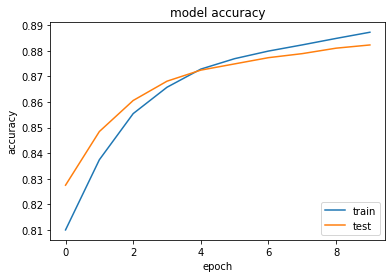

In [32]:
from matplotlib import pyplot as plt
plt.plot(gru_training.history['accuracy'])
plt.plot(gru_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

Bidirectional LSTM Model

In [33]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
bidirect_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
bidirect_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         5177100   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        186880    
 l)                                                              
                                                                 
 time_distributed_3 (TimeDis  (None, None, 43)         5547      
 tributed)                                                       
                                                                 
Total params: 5,369,527
Trainable params: 5,369,527
Non-trainable params: 0
_________________________________________________________________


In [34]:
bidirect_training = bidirect_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.3)

Epoch 1/10
40/40 [==============================] - 11s 178ms/step - loss: 1.6252 - accuracy: 0.7871 - val_loss: 0.6611 - val_accuracy: 0.8304
Epoch 2/10
40/40 [==============================] - 5s 114ms/step - loss: 0.6196 - accuracy: 0.8344 - val_loss: 0.5863 - val_accuracy: 0.8417
Epoch 3/10
40/40 [==============================] - 5s 116ms/step - loss: 0.5587 - accuracy: 0.8475 - val_loss: 0.5359 - val_accuracy: 0.8540
Epoch 4/10
40/40 [==============================] - 4s 91ms/step - loss: 0.5109 - accuracy: 0.8601 - val_loss: 0.4953 - val_accuracy: 0.8645
Epoch 5/10
40/40 [==============================] - 2s 42ms/step - loss: 0.4717 - accuracy: 0.8698 - val_loss: 0.4639 - val_accuracy: 0.8711
Epoch 6/10
40/40 [==============================] - 1s 36ms/step - loss: 0.4402 - accuracy: 0.8757 - val_loss: 0.4412 - val_accuracy: 0.8751
Epoch 7/10
40/40 [==============================] - 2s 52ms/step - loss: 0.4152 - accuracy: 0.8797 - val_loss: 0.4236 - val_accuracy: 0.8781
Epoch 8/1

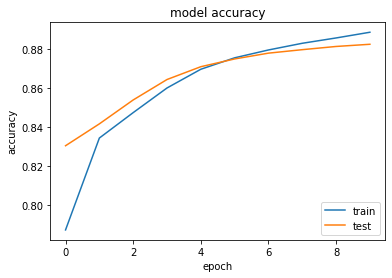

In [35]:
from matplotlib import pyplot as plt
plt.plot(bidirect_training.history['accuracy'])
plt.plot(bidirect_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

Models Evaluation

In [36]:
results = rnn_model.evaluate(x_test, y_test, batch_size=128,verbose=0)
print(rnn_model.metrics_names)
print(results)

['loss', 'accuracy']
[0.42914658784866333, 0.8706431984901428]


In [37]:
results = lstm_model.evaluate(x_test, y_test, batch_size=128,verbose=0)
print(lstm_model.metrics_names)
print(results)

['loss', 'accuracy']
[0.4029112160205841, 0.8784283995628357]


In [38]:
results = gru_model.evaluate(x_test, y_test, batch_size=128,verbose=0)
print(lstm_model.metrics_names)
print(results)

['loss', 'accuracy']
[0.38613006472587585, 0.8809340000152588]


In [39]:
results = bidirect_model.evaluate(x_test, y_test, batch_size=128,verbose=0)
print(bidirect_model.metrics_names)
print(results)

['loss', 'accuracy']
[0.3978657126426697, 0.8816834688186646]


Predict the test data

In [40]:
import numpy as np
import pandas as pd
import os
test_data = []
f = open("/content/drive/MyDrive/dataset/nlp_test_dataset.txt", "r")
rowtext = []
for line in f:
  if line == "\n":
    test_data.append(rowtext)
    rowtext = []
  else:
    if line!='.\n' and line!=',\n':
      rowtext.append(line.strip('\n'))
print(test_data[0])

['Rockwell', 'International', 'Corp.', "'s", 'Tulsa', 'unit', 'said', 'it', 'signed', 'a', 'tentative', 'agreement', 'extending', 'its', 'contract', 'with', 'Boeing', 'Co.', 'to', 'provide', 'structural', 'parts', 'for', 'Boeing', "'s", '747', 'jetliners']


In [41]:
test_df = pd.DataFrame(columns=["text"])
test_df["text"] = test_data

In [42]:
test_df.head()

,text
0,"[Rockwell, International, Corp., 's, Tulsa, un..."
1,"[Rockwell, said, the, agreement, calls, for, i..."
2,"[These, include, among, other, parts, each, je..."
3,"[Under, the, existing, contract, Rockwell, sai..."
4,"[Rockwell, based, in, El, Segundo, Calif., is,..."


In [43]:
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(test_df["text"])
sequences = []
for i in range(len(test_data)):
  sequence = tokenizer.texts_to_sequences([test_data[i]])
  sequences.append(sequence[0])
print(sequences[0])
print(sequences[30])
test_X_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
tag_tokenizer.word_index['<PAD>'] = 0
tag_tokenizer.index_word[0] = '<PAD>'

[1353, 270, 86, 8, 3413, 232, 14, 18, 917, 4, 2270, 432, 3414, 26, 307, 24, 1093, 101, 2, 433, 3415, 918, 7, 1093, 8, 3416, 3417]
[17, 82, 8, 335, 3, 70, 18, 21, 581, 7, 4, 3471, 10, 3472, 22]


In [44]:
rnn_output = rnn_model.predict(test_X_padded)
rnn_pred_sequences = []
for i in range(len(rnn_output)):
    pred_tags = [tag_tokenizer.index_word[np.argmax(p)] for p in rnn_output[i]]
    rnn_pred_sequences.append(pred_tags)
for i in range(5):
  print(test_df.iloc[i])
  print(rnn_pred_sequences[i])
  print("\n")

63/63 [==============================] - 1s 17ms/step
text    [Rockwell, International, Corp., 's, Tulsa, un...
Name: 0, dtype: object
['vbg', 'nn', '<PAD>', 'pos', 'pos', 'nn', 'vbd', 'in', 'in', 'dt', 'nn', 'nn', 'nn', 'vbp', 'vbp', 'in', 'rb', 'nns', 'in', 'in', 'jj', 'in', 'in', 'nn', 'nn', 'jj', 'jj', 'nn', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


text    [Rockwell, said, the, agreem

In [45]:
lstm_output = lstm_model.predict(test_X_padded)
lstm_pred_sequences = []
for i in range(len(lstm_output)):
    pred_tags = [tag_tokenizer.index_word[np.argmax(p)] for p in lstm_output[i]]
    lstm_pred_sequences.append(pred_tags)
for i in range(5):
  print(test_df.iloc[i])
  print(len(test_df.iloc[i]))
  print(lstm_pred_sequences[i])
  print(len(lstm_pred_sequences[i]))
  print("\n")

63/63 [==============================] - 1s 6ms/step
text    [Rockwell, International, Corp., 's, Tulsa, un...
Name: 0, dtype: object
1
['vbn', 'nn', 'jj', 'pos', 'nnp', 'vbd', 'vbd', 'in', 'rb', 'dt', 'rb', 'nn', 'nn', 'vbp', 'nnp', 'in', 'vbn', 'nnp', 'in', 'in', 'in', 'nn', 'in', 'in', 'pos', 'jj', 'nn', 'nn', 'nn', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
100


text    [Rockwell, said, the, agre

In [46]:
print(len(test_data))
print(len(test_data[0]))
print(len(sequences))
print(len(sequences[0]))
print(len(test_X_padded))
print(len(test_X_padded[0]))

print(len(rnn_output))
print(len(rnn_output[0]))
print(len(lstm_pred_sequences))
print(len(lstm_pred_sequences[0]))

2012
27
2012
27
2012
100
2012
100
2012
100


In [47]:
gru_output = gru_model.predict(test_X_padded)
gru_pred_sequences = []
for i in range(len(gru_output)):
    pred_tags = [tag_tokenizer.index_word[np.argmax(p)] for p in gru_output[i]]
    gru_pred_sequences.append(pred_tags)
for i in range(5):
  print(test_df.iloc[i])
  print(len(test_df.iloc[i]))
  print(gru_pred_sequences[i])
  print(len(gru_pred_sequences[i]))
  print("\n")

63/63 [==============================] - 1s 5ms/step
text    [Rockwell, International, Corp., 's, Tulsa, un...
Name: 0, dtype: object
1
['vbn', 'nn', 'jj', 'pos', 'nnp', 'nnp', 'vbd', 'in', 'in', 'dt', 'dt', 'dt', 'nn', 'vbp', 'nnp', 'in', 'in', 'nnp', 'in', 'nn', 'nn', 'nn', 'in', 'in', 'pos', 'pos', 'nn', 'nn', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
100


text    [Rockwell, said, the, a

In [48]:
bidirect_output = bidirect_model.predict(test_X_padded)
bidirect_pred_sequences = []
for i in range(len(bidirect_output)):
    pred_tags = [tag_tokenizer.index_word[np.argmax(p)] for p in bidirect_output[i]]
    bidirect_pred_sequences.append(pred_tags)
for i in range(5):
  print(test_df.iloc[i])
  print(len(test_df.iloc[i]))
  print(bidirect_pred_sequences[i])
  print(len(bidirect_pred_sequences[i]))
  print("\n")

63/63 [==============================] - 1s 6ms/step
text    [Rockwell, International, Corp., 's, Tulsa, un...
Name: 0, dtype: object
1
['vbn', 'nn', 'nn', 'pos', 'nnp', 'vbn', 'vbd', 'in', 'in', 'dt', 'vbz', 'nn', 'nn', 'vbp', 'nnp', 'in', 'in', 'nnp', 'nnp', 'nn', 'nn', 'nn', 'in', 'in', 'pos', 'nn', 'nn', 'nn', 'nn', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
100


text    [Rockwell, said, the, agr

Writing to file

In [49]:
nr = len(test_data)
with open('/content/drive/MyDrive/dataset/labeled_test_dataset_lstm.txt', 'w') as f:
  for i in range(nr):
    nc = len(test_data[i])
    for j in range(nc):
      if test_data[i][j]!="<PAD>":
        f.write(str(test_data[i][j])+" " + str(lstm_pred_sequences[i][j] ))
        f.write("\n")

In [50]:
nr = len(test_data)
with open('/content/drive/MyDrive/dataset/labeled_test_dataset_rnn.txt', 'w') as f:
  for i in range(nr):
    nc = len(test_data[i])
    for j in range(nc):
      if test_data[i][j]!="<PAD>":
        f.write(str(test_data[i][j])+" " + str(rnn_pred_sequences[i][j] ))
        f.write("\n")

In [51]:
nr = len(test_data)
with open('/content/drive/MyDrive/dataset/labeled_test_dataset_gru.txt', 'w') as f:
  for i in range(nr):
    nc = len(test_data[i])
    for j in range(nc):
      if test_data[i][j]!="<PAD>":
        f.write(str(test_data[i][j])+" " + str(gru_pred_sequences[i][j] ))
        f.write("\n")

In [52]:
nr = len(test_data)
with open('/content/drive/MyDrive/dataset/labeled_test_dataset_bidirect.txt', 'w') as f:
  for i in range(nr):
    nc = len(test_data[i])
    for j in range(nc):
      if test_data[i][j]!="<PAD>":
        f.write(str(test_data[i][j])+" " + str(bidirect_pred_sequences[i][j] ))
        f.write("\n")

In [70]:
lstm = {}
rnn = {}
bidirect = {}
gru = {}

for i in tag_to_id.keys():
  lstm[i.lower()] = 0
  rnn[i.lower()] = 0
  bidirect[i.lower()] = 0
  gru[i.lower()] = 0

file1 = open('/content/drive/MyDrive/dataset/labeled_test_dataset_lstm.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n")
  if tag in lstm.keys():
    lstm[tag]+=1


file1 = open('/content/drive/MyDrive/dataset/labeled_test_dataset_rnn.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n")
  if tag in rnn.keys():
    rnn[tag]+=1


file1 = open('/content/drive/MyDrive/dataset/labeled_test_dataset_gru.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n")
  if tag in gru.keys():
    gru[tag]+=1


file1 = open('/content/drive/MyDrive/dataset/labeled_test_dataset_bidirect.txt', 'r')
lines = file1.readlines()

for i in lines:
  tag = i.split(" ")[1].strip("\n")
  if tag in bidirect.keys():
    bidirect[tag]+=1

    
waste = []
for i in lstm.keys():
  if lstm[i]<100:
    waste.append(i)
for i in waste:
  del lstm[i]
  del bidirect[i]
  del rnn[i]
  del gru[i]

print(rnn)
print(lstm)
print(gru)
print(bidirect)

{'nn': 8717, 'in': 6632, 'dt': 4408, 'vbz': 826, 'rb': 1083, 'vbn': 597, 'to': 1384, 'vb': 911, 'jj': 2303, 'nns': 2819, 'nnp': 4206, 'cc': 1462, 'pos': 326, 'vbp': 366, 'vbg': 190, 'prp$': 443, 'cd': 1295, '``': 299, "''": 232, 'vbd': 1216, 'md': 390, '$': 319, 'prp': 686, 'jjr': 124, ':': 168}
{'nn': 7662, 'in': 6148, 'dt': 4629, 'vbz': 748, 'rb': 1434, 'vbn': 592, 'to': 1189, 'vb': 571, 'jj': 2790, 'nns': 2963, 'nnp': 4416, 'cc': 1423, 'pos': 410, 'vbp': 455, 'vbg': 201, 'prp$': 403, 'cd': 1553, '``': 323, "''": 272, 'vbd': 1516, 'md': 429, '$': 376, 'prp': 863, 'jjr': 132, ':': 175}
{'nn': 6684, 'in': 6370, 'dt': 4737, 'vbz': 836, 'rb': 1506, 'vbn': 456, 'to': 1385, 'vb': 693, 'jj': 2326, 'nns': 2725, 'nnp': 4435, 'cc': 1614, 'pos': 484, 'vbp': 513, 'vbg': 56, 'prp$': 436, 'cd': 1827, '``': 359, "''": 307, 'vbd': 1431, 'md': 429, '$': 418, 'prp': 1016, 'jjr': 127, ':': 156}
{'nn': 8269, 'in': 6424, 'dt': 4373, 'vbz': 734, 'rb': 1348, 'vbn': 632, 'to': 1155, 'vb': 545, 'jj': 2633, '

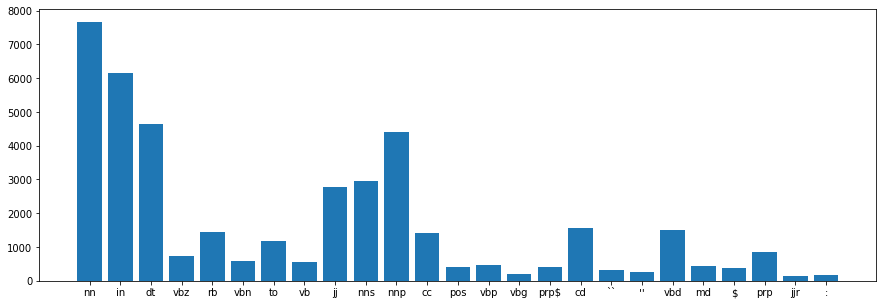

In [76]:
plt.rcParams["figure.figsize"] = (15,5)
plt.bar(range(len(lstm)), lstm.values(), tick_label=lstm.keys())
plt.xticks(range(len(lstm)), list(lstm.keys()))
plt.show()

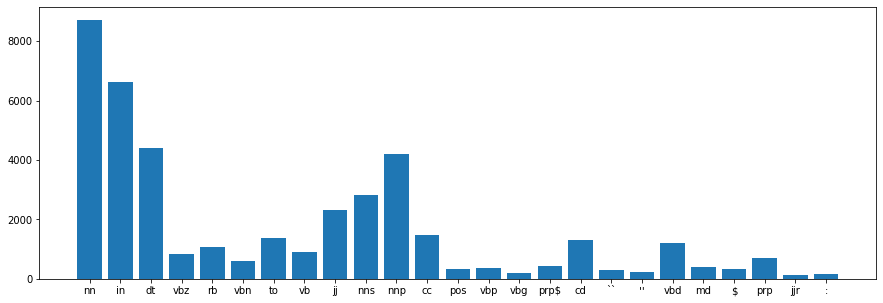

In [78]:
plt.bar(range(len(rnn)), rnn.values(), tick_label=rnn.keys())
plt.xticks(range(len(rnn)), list(rnn.keys()))
plt.show()

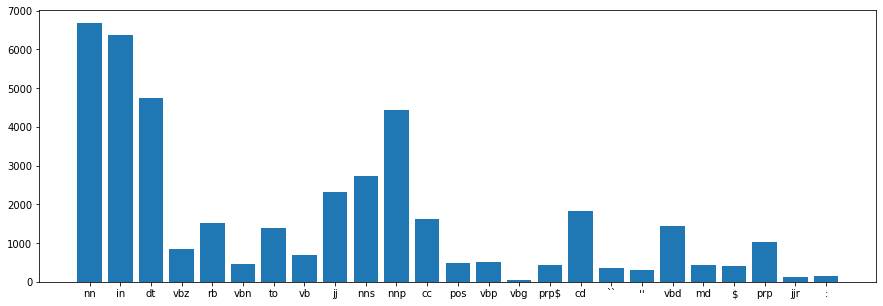

In [79]:
plt.bar(range(len(gru)), gru.values(), tick_label=gru.keys())
plt.xticks(range(len(gru)), list(gru.keys()))
plt.show()

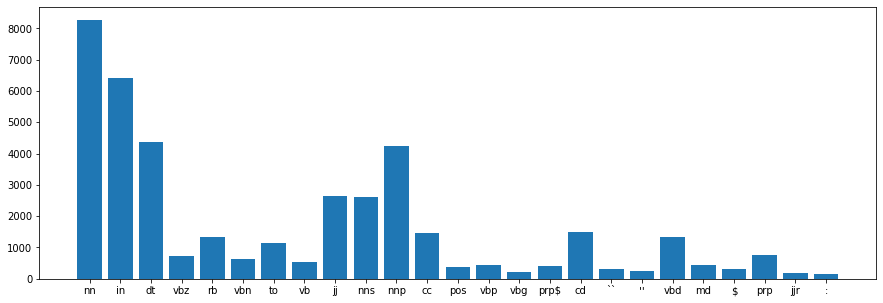

In [80]:
plt.bar(range(len(bidirect)), bidirect.values(), tick_label=bidirect.keys())
plt.xticks(range(len(bidirect)), list(bidirect.keys()))
plt.show()

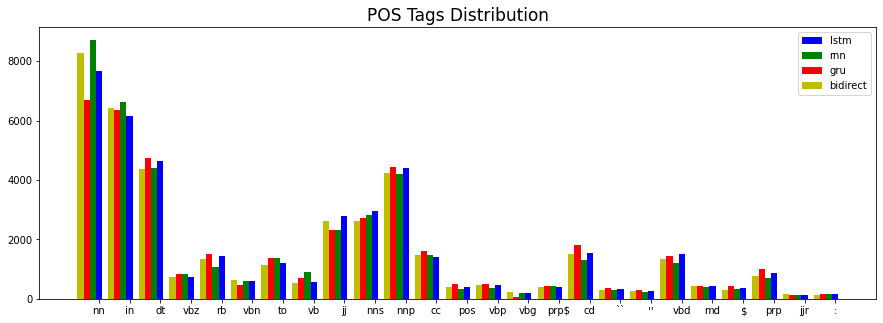

In [84]:
X = np.arange(len(lstm))
ax = plt.subplot(111)

ax.bar(X, lstm.values(), width=0.2, color='b', align='center')
ax.bar(X-0.2, rnn.values(), width=0.2, color='g', align='center')
ax.bar(X-0.4, gru.values(), width=0.2, color='r', align='center')
ax.bar(X-0.6, bidirect.values(), width=0.2, color='y', align='center')

ax.legend(('lstm','rnn','gru','bidirect'))
plt.xticks(X, lstm.keys())
plt.title("POS Tags Distribution", fontsize=17)
plt.show()